In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
import scipy
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm
import random
import pickle
from random import sample
from matplotlib_venn import venn2

### Load Data

In [2]:
KO_SC = sc.read_h5ad('h5ad')

In [3]:
Late_CM = KO_SC[KO_SC.obs.louvain == '0']

In [4]:
SG_DF = pd.read_pickle('pkl')

In [5]:
CM_Cells = sc.read_h5ad('h5ad')
CM_Ordered_Cells = CM_Cells[CM_Cells.obs['rank_pseudotime'].sort_values()]

In [6]:
PATH = ''
Dict_File = open(PATH + "CM_FILTERED_DICT_080521.pkl", "rb")
CM_FILTERED_DICT = pickle.load(Dict_File)

### Process sgRNA

In [7]:
cell_list = []
for cell in SG_DF.index:
    if cell in CM_Cells.obs.index:
        cell_list.append(cell)
SG_DF = SG_DF.loc[cell_list]

In [8]:
### Make Dict of sgRNA 
SG_Targets = []
for sg in SG_DF.columns:
    SG_Targets.append(sg.split('_')[0])
SG_Targets = np.unique(SG_Targets)

SG_Name = []
SG_Indi = []
for sg in SG_Targets:
    if sg == 'NC_Blank':
        SG_Name.append('NC')
        SG_Indi.append('NC_Blank')
    else:
        SG_Name.append(sg)
        sg_list = []
        for indi in SG_DF.columns:
            if indi.split('_')[0] == sg:
                sg_list.append(indi)
        SG_Indi.append(sg_list)
Guide_Dictionary = dict(zip(SG_Name, SG_Indi))

In [9]:
### Cells for each sgRNA
Cell_List = []
for target in SG_DF.columns:
    Cell_Subset = []
    if target == 'NC_Blank':
        for cell in SG_DF.index:
            if sum(SG_DF.loc[cell] >0) != 1:
                continue
            if SG_DF.loc[cell][target] >0:
                Cell_Subset.append(cell)
    else:
        [Cell_Subset.append(i) for i in SG_DF[SG_DF[target] > 0].index]
    Cell_List.append(Cell_Subset)
SG_Dictionary = dict(zip(SG_DF.columns, Cell_List))

In [10]:
### List of perturbed cells
Perturbed_Cells = []
for target in Guide_Dictionary.keys():
    if target == 'NC':
        continue
        
    Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
    for i in Filtered_SG:
        Perturbed_Cells.extend(SG_Dictionary[i])
    
Perturbed_Cells = np.unique(Perturbed_Cells)

In [11]:
sg_id = []
for cell in CM_Cells.obs.index:
    if cell in SG_Dictionary['NC_Blank']:
        sg_id.append('NC')
    elif cell in Perturbed_Cells:
        sg_id.append('TBX5_ENH')
    else:
        sg_id.append('Other')
CM_Cells.obs['sg_id'] = sg_id

In [12]:
CM_Cells_Clean = CM_Cells[CM_Cells.obs.sg_id != 'Other']
CM_Cells_Clean = CM_Cells_Clean[CM_Cells_Clean.obs.sg_id == 'NC']

In [13]:
sc.tl.rank_genes_groups(CM_Cells_Clean, groupby='louvain', method='wilcoxon')

Trying to set attribute `.obs` of view, copying.
... storing 'sg_id' as categorical


### Expression of mid genes

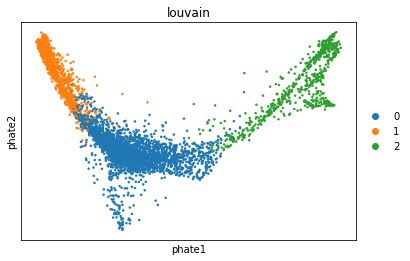

In [14]:
sce.pl.phate(KO_SC, color = 'louvain')

In [15]:
%%capture
Cluster = '0'
Pos_Genes = CM_Cells_Clean.uns['rank_genes_groups']['names'][Cluster][CM_Cells_Clean.uns['rank_genes_groups']['scores'][Cluster] > 0]
Pval_Genes = CM_Cells_Clean.uns['rank_genes_groups']['names'][Cluster][CM_Cells_Clean.uns['rank_genes_groups']['pvals_adj'][Cluster] < 0.05]
Sig_Genes = [i for i in Pval_Genes if i in Pos_Genes]
Sig_Gene_Raw_Index = []
for gene in Sig_Genes:
    try:
        Sig_Gene_Raw_Index.append(np.argwhere(KO_SC.raw.var_names == gene)[0][0])
    except:
        print(gene)

In [16]:
Gene_Set = Sig_Gene_Raw_Index
Cluster_DF = KO_SC[KO_SC.obs.louvain == '0']

In [17]:
WT_Cells_Expression = np.mean(Cluster_DF[Cluster_DF.obs.Sample == 'WT'].raw.X[:,Gene_Set].todense().tolist(), axis=1).tolist()
Perturbed_Cells_Expression = np.mean(Cluster_DF[Cluster_DF.obs.Sample != 'WT'].raw.X[:,Gene_Set].todense().tolist(), axis=1).tolist()

In [18]:
Sampling_Amount = 1000
Sampling_List = list(range(Sampling_Amount))
Test_Target = Perturbed_Cells_Expression


## Average Expression of Pattern in Perturbed Cells
Perturbed_Cells = len(Test_Target)
Perturbed_Average = np.mean(Test_Target)/np.log(2)

### Randomly Sample Same Number of Perturbed Cells from NC and get average

Total_NC_Cells = len(WT_Cells_Expression)
Random_Numbers = [i for i in range(Total_NC_Cells)]
NC_Averages = []

random.seed(0)
for value in Sampling_List:
    Random_Positions = sample(Random_Numbers, Perturbed_Cells)
    Randomized_List = [WT_Cells_Expression[i] for i in Random_Positions]
    Randomized_Mean = np.mean(Randomized_List)/np.log(2)
    NC_Averages.append(Randomized_Mean)
Perturbed_Deviation = (Perturbed_Average-np.mean(NC_Averages))/np.std(NC_Averages)

In [28]:
#cdf for below sf for above
P_VALUE_CDF  = '{:0.1e}'.format(scipy.stats.norm.cdf(Perturbed_Deviation))
P_VALUE_SF  = '{:0.1e}'.format(scipy.stats.norm.sf(Perturbed_Deviation))

if scipy.stats.norm.cdf(Perturbed_Deviation) < scipy.stats.norm.sf(Perturbed_Deviation):
    P_VALUE = P_VALUE_CDF
else:
    P_VALUE = P_VALUE_SF
print(P_VALUE)

8.0e-164


### Plot Distributions

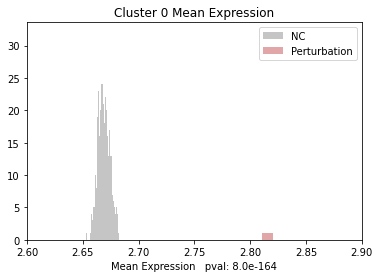

In [27]:
x = Perturbed_Average
y = NC_Averages

plt.hist(y, alpha=0.5, label='NC', bins = 100, color = '#8c8c8c')
plt.hist(x, alpha=0.5, label='Perturbation', bins = 100, color = '#c44e52')
plt.legend(loc='upper right')
plt.xlabel('Mean Expression   pval: ' + P_VALUE)
plt.xlim(2.6,2.9)
plt.title('Cluster ' + Cluster + ' Mean Expression')

plt.savefig('pdf')

### Expression of late genes

In [27]:
%%capture
Cluster = '1'
Pos_Genes = CM_Cells_Clean.uns['rank_genes_groups']['names'][Cluster][CM_Cells_Clean.uns['rank_genes_groups']['scores'][Cluster] > 0]
Pval_Genes = CM_Cells_Clean.uns['rank_genes_groups']['names'][Cluster][CM_Cells_Clean.uns['rank_genes_groups']['pvals_adj'][Cluster] < 0.05]
Sig_Genes = [i for i in Pval_Genes if i in Pos_Genes]
Sig_Gene_Raw_Index = []
for gene in Sig_Genes:
    try:
        Sig_Gene_Raw_Index.append(np.argwhere(KO_SC.raw.var_names == gene)[0][0])
    except:
        print(gene)

In [33]:
Gene_Set = Sig_Gene_Raw_Index
Cluster_DF = KO_SC[KO_SC.obs.louvain == '0']

In [34]:
WT_Cells_Expression = np.mean(Cluster_DF[Cluster_DF.obs.Sample == 'WT'].raw.X[:,Gene_Set].todense().tolist(), axis=1).tolist()
Perturbed_Cells_Expression = np.mean(Cluster_DF[Cluster_DF.obs.Sample != 'WT'].raw.X[:,Gene_Set].todense().tolist(), axis=1).tolist()
ENH3_Cells_Expression = np.mean(Cluster_DF[Cluster_DF.obs.Sample == 'ENH3'].raw.X[:,Gene_Set].todense().tolist(), axis=1).tolist()
ENH5_Cells_Expression = np.mean(Cluster_DF[Cluster_DF.obs.Sample == 'ENH5'].raw.X[:,Gene_Set].todense().tolist(), axis=1).tolist()

In [35]:
Sampling_Amount = 1000
Sampling_List = list(range(Sampling_Amount))
Test_Target = Perturbed_Cells_Expression


## Average Expression of Pattern in Perturbed Cells
Perturbed_Cells = len(Test_Target)
Perturbed_Average = np.mean(Test_Target)/np.log(2)

### Randomly Sample Same Number of Perturbed Cells from NC and get average

Total_NC_Cells = len(WT_Cells_Expression)
Random_Numbers = [i for i in range(Total_NC_Cells)]
NC_Averages = []

random.seed(0)
for value in Sampling_List:
    Random_Positions = sample(Random_Numbers, Perturbed_Cells)
    Randomized_List = [WT_Cells_Expression[i] for i in Random_Positions]
    Randomized_Mean = np.mean(Randomized_List)/np.log(2)
    NC_Averages.append(Randomized_Mean)
Perturbed_Deviation = (Perturbed_Average-np.mean(NC_Averages))/np.std(NC_Averages)

In [36]:
#cdf for below sf for above
P_VALUE_CDF  = '{:0.1e}'.format(scipy.stats.norm.cdf(Perturbed_Deviation))
P_VALUE_SF  = '{:0.1e}'.format(scipy.stats.norm.sf(Perturbed_Deviation))

if scipy.stats.norm.cdf(Perturbed_Deviation) < scipy.stats.norm.sf(Perturbed_Deviation):
    P_VALUE = P_VALUE_CDF
else:
    P_VALUE = P_VALUE_SF
print(P_VALUE)

4.9e-35


### Plot Distributions

Text(0.5, 1.0, 'Cluster 1 Mean Expression')

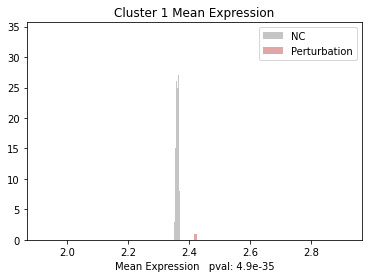

In [37]:
x = Perturbed_Average
y = NC_Averages

plt.hist(y, alpha=0.5, label='NC', bins = 100, color = '#8c8c8c')
plt.hist(x, alpha=0.5, label='Perturbation', bins = 100, color = '#c44e52')
plt.legend(loc='upper right')
plt.xlabel('Mean Expression   pval: ' + P_VALUE)
plt.title('Cluster ' + Cluster + ' Mean Expression')

#plt.savefig('pdf')